# Import

In [1]:
from matplotlib        import collections             as matcoll
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import TwoSlopeNorm
from matplotlib.pyplot import rc_context
from scipy.cluster     import hierarchy

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import math
import glob
import h5py
import sys
import os

main_path = '/gpfs/data/osmanlab/Processing/HPL/Histomorphological-Phenotype-Learning_TCGA'
sys.path.append(main_path)
from models.clustering.logistic_regression_leiden_clusters import *
from models.evaluation.folds import load_existing_split
from models.clustering.correlations import *
from models.clustering.data_processing import *
from models.clustering.leiden_representations import include_tile_connections_frame
from data_manipulation.utils import store_data


2025-03-04 15:56:38.213871: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


# Variables

In [2]:
# Workspace path.

# Resolution and fold for the tile clustering and slide representations.
resolution     = 2.0
fold_number    = 3
groupby        = 'leiden_%s' % resolution

# Folder run.
meta_folder     = 'comb005_v01'
matching_field  = 'samples'
meta_field      = 'labels'


# Pickle files.
folds_pickle = '%s/comb005_001_all_os_4folds.pkl'  % main_path

# Tile representation files.
h5_complete_path   = '%s/results/BarlowTwins_3_twentyE/comb005_5setsNoNYU_40x_896px/h224_w224_n3_zdim128/hdf5_comb005_5setsNoNYU_40x_896px_he_complete_allos.h5' % main_path
h5_additional_path = '%s/results/BarlowTwins_3_twentyE/comb005_TCGA_40x_896px/h224_w224_n3_zdim128/hdf5_comb005_TCGA_40x_896px_he_complete_OS.h5' % main_path

# Annotation files.
tcga_csv  = '%s/labels_TCGA_TMB_unique.csv' % main_path

# Run path.
main_cluster_path = h5_complete_path.split('hdf5_')[0]
main_cluster_path = os.path.join(main_cluster_path, meta_folder)
adatas_path       = os.path.join(main_cluster_path, 'adatas')
figure_path       = os.path.join(main_cluster_path, 'leiden_%s_fold%s' % (str(resolution).replace('.','p'),fold_number))
figure_path       = os.path.join(figure_path,       'figures')
if not os.path.isdir(figure_path):
    os.makedirs(figure_path)

# Immune landscape sample annotations.
tcga_landscape_df = pd.read_csv(tcga_csv)


# Grab tiles and slides representations

In [3]:
def create_histo_annotation_df(h5_hist_anno_path, additional_df):
    with h5py.File(h5_hist_anno_path, 'r') as content:
        slides   = [slide.decode("utf-8").split('_')[0] for slide in content['combined_slides']]
        tiles    = [tile.decode("utf-8").split('.')[0] for tile in content['combined_tiles']]
        histtype = [type_.decode("utf-8") for type_ in content['combined_hist_subtype']]
        histo_df = pd.DataFrame(slides, columns=['slides'])
        histo_df['tiles'] = tiles
        histo_df['histtype'] = histtype

    selected_anno = ['acinar', 'lepidic', 'micropapillary', 'papillary', 'solid']

    additional_df['slides'] = additional_df['slides'].astype(str)
    histo_complete_df = additional_df.merge(histo_df, how='inner', left_on=['slides','tiles'], right_on=['slides','tiles'])
    histo_complete_df = histo_complete_df.loc[histo_complete_df['histtype'].isin(selected_anno)]

    return histo_complete_df

In [4]:
''' Get representations for slide representation correlations. '''
# Fold
folds = load_existing_split(folds_pickle)
fold = folds[fold_number]

# Read cohort CSVs.
dataframes, complete_df, leiden_clusters   = read_csvs(adatas_path, matching_field, groupby, fold_number, fold, h5_complete_path, h5_additional_path, additional_as_fold=False, force_fold=None)
train_df, valid_df, test_df, additional_df = dataframes
complete_df['tiles']   = complete_df['tiles'].apply(lambda x: x.split('.jpeg')[0])
if additional_df is not None:
    additional_df['tiles'] = additional_df['tiles'].apply(lambda x: x.split('.jpeg')[0])

# annotated_df           = complete_df.merge(hovernet_df, how='inner', left_on=['slides', 'tiles'], right_on=['slides', 'tiles'])
#cluster_anno_df        = complete_df[complete_df['annotated_20x_tile_count']>=annotation_restriction]

''' Get representations for slide representation correlations. '''
frames = build_cohort_representations(meta_folder, meta_field, matching_field, groupby, fold_number, folds_pickle, h5_complete_path, h5_additional_path, 'clr', 100)
complete_df, additional_complete_df, frame_clusters, frame_samples, features = frames
complete_df.columns            = complete_df.columns.astype(str)
if additional_complete_df is not None:
    if matching_field == 'samples' and matching_field not in additional_complete_df.columns:
        additional_complete_df[matching_field] = additional_complete_df['slides']
    additional_complete_df.columns = additional_complete_df.columns.astype(str)

''' Read clustering file '''
adata_train, h5ad_path = read_h5ad_reference(h5_complete_path, meta_folder, groupby, fold_number)

# Leiden clusters dendrogram.
#leiden_linkage_method = 'average'
#leiden_cor_method     = 'spearman'
#sc.tl.dendrogram(adata_train, groupby, use_rep='X', linkage_method=leiden_linkage_method, cor_method=leiden_cor_method)
#leiden_linkage = adata_train.uns['dendrogram_%s' % groupby]['linkage']



/gpfs/data/osmanlab/Processing/HPL/Histomorphological-Phenotype-Learning_TCGA/models/clustering/data_processing.py:119: DtypeWarning: Columns (10,12) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df    = pd.read_csv(train_csv)
/gpfs/data/osmanlab/Processing/HPL/Histomorphological-Phenotype-Learning_TCGA/models/clustering/data_processing.py:120: DtypeWarning: Columns (10,12) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df     = pd.read_csv(test_csv)
/gpfs/data/osmanlab/Processing/HPL/Histomorphological-Phenotype-Learning_TCGA/models/clustering/data_processing.py:119: DtypeWarning: Columns (10,12) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df    = pd.read_csv(train_csv)
/gpfs/data/osmanlab/Processing/HPL/Histomorphological-Phenotype-Learning_TCGA/models/clustering/data_processing.py:120: DtypeWarning: Columns (10,12) have mixed types. Specify dtype option on import or set low_me

In [5]:
''' Prepare manual annotations for histological subtypes.'''
#if additional_df is not None:
#    histo_complete_df  = create_histo_annotation_df(h5_hist_anno_path, additional_df)


' Prepare manual annotations for histological subtypes.'

In [15]:
tcga_landscape_df

,samples,log2_TMB,LN
0,TCGA-D3-A1Q1,-2.247242,1
1,TCGA-D3-A1Q4,-0.788247,1
2,TCGA-D3-A1Q5,-0.389757,1
3,TCGA-D3-A1Q6,0.774525,1
4,TCGA-D3-A1Q7,-2.077394,1
...,...,...,...
130,TCGA-WE-AA9Y,0.585059,1
131,TCGA-WE-AAA0,4.898009,1
132,TCGA-WE-AAA3,2.876213,1
133,TCGA-XV-AB01,1.860637,1


# Correlations

In [7]:
corr_method   = 'spearman'   # Correlation method.
corr_matching = 'samples'
pval_th       = 0.01


correlations_dict = dict()

''' Leiden Cluster Dendrogram'''
#file_name = h5_complete_path.split('/hdf5_')[1].split('.h5')[0] + '_%s__fold%s_%s_leiden_dendrogram' % (groupby.replace('.', 'p'), fold_number, meta_folder)
#sc.tl.dendrogram(adata_train, groupby=groupby, cor_method='pearson', linkage_method='average', optimal_ordering=True)
correlations_dict[groupby] = dict()
#correlations_dict[groupby]['file_name'] = file_name
#correlations_dict[groupby]['linkage']   = adata_train.uns['dendrogram_leiden_2.0']['linkage']


''' Landscape '''
#file_name = h5_complete_path.split('/hdf5_')[1].split('.h5')[0] + '_%s__fold%s_%s_landscape' % (groupby.replace('.', 'p'), fold_number, meta_folder)
all_data_rho, all_data_pval, all_data_samples, mask, cdf  = correlate_clusters_annotation(slide_rep_df=complete_df, annotations_df=tcga_landscape_df, purity_field=meta_field,
                                                                     matching_field=corr_matching, corr_method=corr_method, pval_th=pval_th, field_th=0.05*len(features),
                                                                     groupby=groupby, fold_number=fold_number, directory=main_cluster_path, file_name=None)
correlations_dict['landscape'] = dict()
#correlations_dict['landscape']['file_name'] = file_name
correlations_dict['landscape']['data']      = all_data_rho, all_data_pval, mask


In [16]:
def get_col_colors(cox_os_clusters, cox_pfs_clusters, immune_hot_clusters, p_th):

    colors        = []
    colors_masked = []

    if immune_hot_clusters is not None:
        cmap_PiYG = sns.diverging_palette(20, 250, as_cmap=True)
        norm      = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
        immune_clusters = [1]*cox_pfs_clusters.shape[0]
        for key in immune_hot_clusters:
            if key == 'hot':
                value = -1
            elif key == 'warm':
                value = -0.5
            elif key == 'cold':
                value = 0
            for cluster in immune_hot_clusters[key]:
                immune_clusters[cluster] = value
        column_immune_colors       = pd.Series([cmap_PiYG(norm(coef)) for cluster, coef in enumerate(immune_clusters)], name='Hot/Warm/Cold Lymphocytic Infiltration')
        if cox_os_clusters is not None:
            coef_df          = cox_os_clusters.sort_values(by=groupby)
            column_immune_colors.index = coef_df[groupby].astype(str)
        else:
            column_immune_colors.index = column_immune_colors.index.astype(str)
        colors.append(column_immune_colors)
        colors_masked.append(column_immune_colors)

    # Column colors.
    if cox_os_clusters is not None:
        coef_df   = cox_os_clusters.sort_values(by=groupby)
        cmap_PiYG = plt.cm.PiYG_r
        norm      = TwoSlopeNorm(vmin=coef_df['coef'].min(), vcenter=0, vmax=coef_df['coef'].max())
        column_os_colors              = pd.Series([cmap_PiYG(norm(coef)) for p, coef in zip(coef_df['p'], coef_df['coef'])], name='Cox Coefficient OS')
        column_os_colors_masked       = pd.Series([cmap_PiYG(norm(coef)) if p <p_th else cmap_PiYG(norm(0))[:3] for p, coef in zip(coef_df['p'], coef_df['coef'])], name='Cox Coefficient OS')
        column_os_colors_masked.index = coef_df[groupby].astype(str)
        column_os_colors.index        = coef_df[groupby].astype(str)
        colors.append(column_os_colors)
        colors_masked.append(column_os_colors_masked)

    if cox_pfs_clusters is not None:
        cox_pfs_clusters = cox_pfs_clusters.sort_values(by=groupby)
        cmap_PiYG = plt.cm.PiYG_r
        norm                     = TwoSlopeNorm(vmin=cox_pfs_clusters['coef'].astype(float).min(), vcenter=0, vmax=cox_pfs_clusters['coef'].astype(float).max())
        column_pfs_colors        = pd.Series([cmap_PiYG(norm(coef)) for p, coef in zip(cox_pfs_clusters['p'], cox_pfs_clusters['coef'])], name='Cox Coefficient RFS')
        column_pfs_colors_masked = pd.Series([cmap_PiYG(norm(coef)) if p <p_th else cmap_PiYG(norm(0))[:3] for p, coef in zip(cox_pfs_clusters['p'], cox_pfs_clusters['coef'])], name='Cox Coefficient RFS')
        column_pfs_colors.index        = coef_df[groupby].astype(str)
        column_pfs_colors_masked.index = coef_df[groupby].astype(str)
        colors.append(column_pfs_colors)
        colors_masked.append(column_pfs_colors)

    if len(colors) != 0:
        colors = pd.concat(colors,axis=1)
        colors_masked = pd.concat(colors_masked,axis=1)
    else:
        colors        = None
        colors_masked = None

    return colors, colors_masked

def fixedWidthClusterMap(dataFrame, mask, x_label, y_label, vcenter=0, annot=True, fmt='.2f', col_linkage=None, row_linkage=None, 
                        fontsize_ticks=28, fontsize_labels=30, fontsize_annot=20, dendrogram_ratio=0.2, 
                        immune_hot_clusters=None, cox_os_clusters=None, cox_pfs_clusters=None, 
                        cellSizePixels_x=50, cellSizePixels_y=50, p_th=0.05, offset_col_color=2, 
                        resize_col_den=1.0, linewidths=5.0, row_cluster=True, col_cluster=True, round_cbar=2, cmap=sns.diverging_palette(250, 20, as_cmap=True)):
    sns.set_theme(style='white')

    colors, colors_masked = get_col_colors(cox_os_clusters, cox_pfs_clusters, immune_hot_clusters, p_th)

    # Calculate the figure size, this gets us close, but not quite to the right place
    dpi = matplotlib.rcParams['figure.dpi']
    marginWidth  = (matplotlib.rcParams['figure.subplot.right']-matplotlib.rcParams['figure.subplot.left'])
    marginHeight = (matplotlib.rcParams['figure.subplot.top']-matplotlib.rcParams['figure.subplot.bottom'])
    Ny,Nx = dataFrame.shape
    figWidth = (Nx*cellSizePixels_x/dpi)/0.8/marginWidth
    figHeigh = ((Ny+offset_col_color)*cellSizePixels_y/dpi)/0.8/marginHeight

    # do the actual plot
    vmax = np.nanmax(dataFrame[~mask].values)
    if vcenter == 0:
        vmin = -vmax
        cbar_kws = dict()
    else:
        vmin = np.nanmin(dataFrame[~mask].values)
        ticks = np.array([vmin*1.01, (vmin+vcenter)/2, vcenter, (vmax+vcenter)/2, vmax*0.99])
        ticks = np.round(ticks, round_cbar)
        cbar_kws = dict(ticks=ticks)

    if col_linkage is None and col_cluster:
        Z = hierarchy.linkage(y=dataFrame.T, method='ward', metric='euclidean', optimal_ordering=True)
        col_linkage = Z

    if row_linkage is None and col_cluster:
        Z = hierarchy.linkage(y=dataFrame, method='ward', metric='euclidean', optimal_ordering=True)
        row_linkage = Z

    #print(vmin, vcenter, vmax)
    norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
    grid = sns.clustermap(dataFrame, vmin=vmin, vmax=vmax, method='ward', metric='euclidean', annot=annot, mask=mask, col_linkage=col_linkage, row_linkage=row_linkage, fmt=fmt, col_colors=colors, tree_kws=dict(linewidths=linewidths), norm=norm,
                          cmap=cmap, dendrogram_ratio=dendrogram_ratio, annot_kws={"size": fontsize_annot,'fontstyle':'italic','fontweight':'bold'},  yticklabels=True,  xticklabels=True,
                          row_cluster=row_cluster, col_cluster=col_cluster, figsize=(figWidth, figHeigh), cbar_kws=cbar_kws)

    if colors is not None:
        grid.ax_col_colors.set_yticklabels(grid.ax_col_colors.get_ymajorticklabels(), fontsize=fontsize_ticks)

    # calculate the size of the heatmap axes
    axWidth  = (Nx*cellSizePixels_x)/(figWidth*dpi)
    axHeight = (Ny*cellSizePixels_y)/(figHeigh*dpi)

    # calculate size of column colors
    ax_colors_height = (offset_col_color*cellSizePixels_y)/(figWidth*dpi)

    # resize heatmap
    ax_heatmap_orig_pos = grid.ax_heatmap.get_position()
    grid.ax_heatmap.set_position([ax_heatmap_orig_pos.x0, ax_heatmap_orig_pos.y0, axWidth, axHeight])

    # resize row dendrogram to match
    ax_row_orig_pos = grid.ax_row_dendrogram.get_position()
    grid.ax_row_dendrogram.set_position([ax_row_orig_pos.x0, ax_row_orig_pos.y0, ax_row_orig_pos.width, axHeight])

    # resize col_colors
    if colors is not None:
        ax_col_colors_orig_pos = grid.ax_col_colors.get_position()
        grid.ax_col_colors.set_position([ax_col_colors_orig_pos.x0, ax_heatmap_orig_pos.y0+axHeight+0.01, axWidth, ax_colors_height])

    # resize col dendrogram to match
    ax_col_orig_pos = grid.ax_col_dendrogram.get_position()
    grid.ax_col_dendrogram.set_position([ax_col_orig_pos.x0, ax_heatmap_orig_pos.y0+axHeight+ax_colors_height+0.01, axWidth, ax_col_orig_pos.height*resize_col_den])

    # tick_locator = ticker.MaxNLocator(nbins=cbar_bins)
    # grid.ax_cbar.cla.locator = tick_locator
    # grid.ax_cbar.cla.update_ticks()

    ax_cbar_orig_pos = grid.ax_cbar.get_position()
    grid.ax_cbar.set_position([ax_row_orig_pos.x0+ax_row_orig_pos.width*0.25, ax_heatmap_orig_pos.y0+axHeight, ax_row_orig_pos.width*0.25, ax_col_orig_pos.height*resize_col_den])

    grid.ax_cbar.tick_params(labelsize=fontsize_ticks*0.9, length=10)
    [label.set_fontweight('bold') for label in grid.ax_cbar.get_yticklabels()]

    grid.ax_heatmap.set_xlabel('\n%s' % x_label, fontsize=fontsize_labels, fontweight='bold')
    grid.ax_heatmap.set_ylabel('\n%s' % y_label, fontsize=fontsize_labels, fontweight='bold')

    grid.ax_heatmap.set_xticklabels(grid.ax_heatmap.get_xmajorticklabels(), fontsize=fontsize_ticks, weight='bold')
    grid.ax_heatmap.set_yticklabels(grid.ax_heatmap.get_ymajorticklabels(), fontsize=fontsize_ticks, weight='bold', rotation=0)

    if colors is not None:
        [label.set_fontweight('bold') for label in grid.ax_col_colors.get_yticklabels()]

    for axis in ['top','bottom','left','right']:
        grid.ax_heatmap.spines[axis].set_linewidth(4)

    return grid # return ClusterGrid object

TMB Spearman correlation (values)


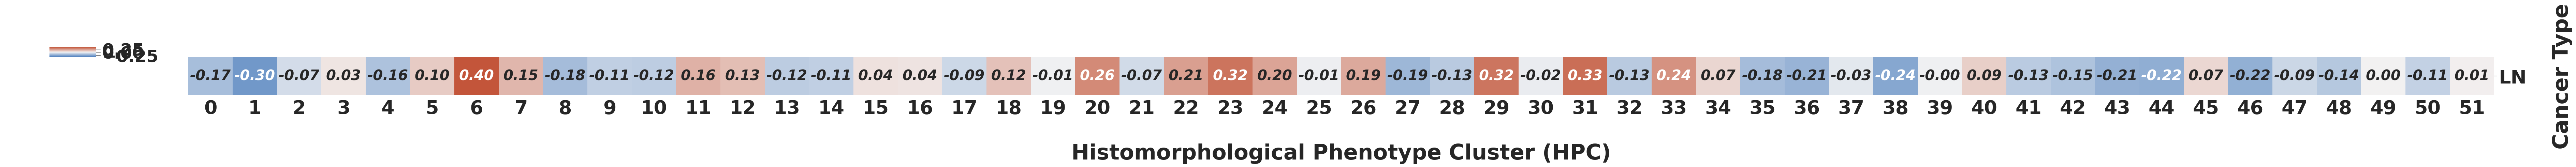

TMB Spearman correlation (p-values)


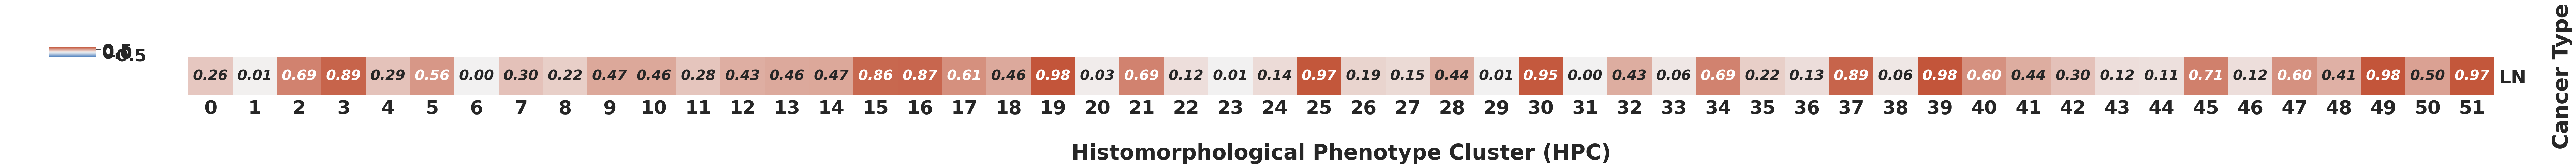

In [19]:
x_label = 'Histomorphological Phenotype Cluster (HPC)'
y_label = 'Cancer Type'
cellSizePixels_x  = 130
cellSizePixels_y  = 110
dendrogram_ratio  = (0.05, 0.2)
fontsize_ticks    = 40
fontsize_labels   = 45
fontsize_annot    = 30
linewidths        = 7

#cmpN = matplotlib.colors.LinearSegmentedColormap.from_list("", ['#C7B60A', 'white', '#6F2DA8'])


#all_data_rho, all_data_pval, mask = correlations_dict['landscape']['data']
c_indexes_u = all_data_rho
p_values = all_data_pval
p_th = 1.
#p_th = 0.1
c_i  = 0.0
c_indexes_vis = c_indexes_u
p_values_vis  = p_values
mask_vis      = p_values_vis > p_th
g = fixedWidthClusterMap(dataFrame=c_indexes_vis, mask=mask_vis, x_label=x_label, y_label=y_label, p_th=p_th, fmt='.2f', vcenter=c_i,
                         fontsize_ticks=fontsize_ticks, fontsize_labels=fontsize_labels, fontsize_annot=fontsize_annot, dendrogram_ratio=dendrogram_ratio,
                         cellSizePixels_x=cellSizePixels_x, cellSizePixels_y=cellSizePixels_y, offset_col_color=0, resize_col_den=1.3, linewidths=linewidths, 
                         row_cluster=False, col_cluster=False)
print('TMB Spearman correlation (values)')
plt.show()


c_i  = 0.0
c_indexes_vis = p_values_vis #c_indexes_ci
g = fixedWidthClusterMap(dataFrame=c_indexes_vis, mask=mask_vis, x_label=x_label, y_label=y_label, p_th=p_th, fmt='.2f', vcenter=c_i,
                        fontsize_ticks=fontsize_ticks, fontsize_labels=fontsize_labels, fontsize_annot=fontsize_annot, dendrogram_ratio=dendrogram_ratio,
                        cellSizePixels_x=cellSizePixels_x, cellSizePixels_y=cellSizePixels_y, offset_col_color=0, resize_col_den=1.3, linewidths=linewidths,
                        row_cluster=False, col_cluster=False)
print('TMB Spearman correlation (p-values)')
plt.show()

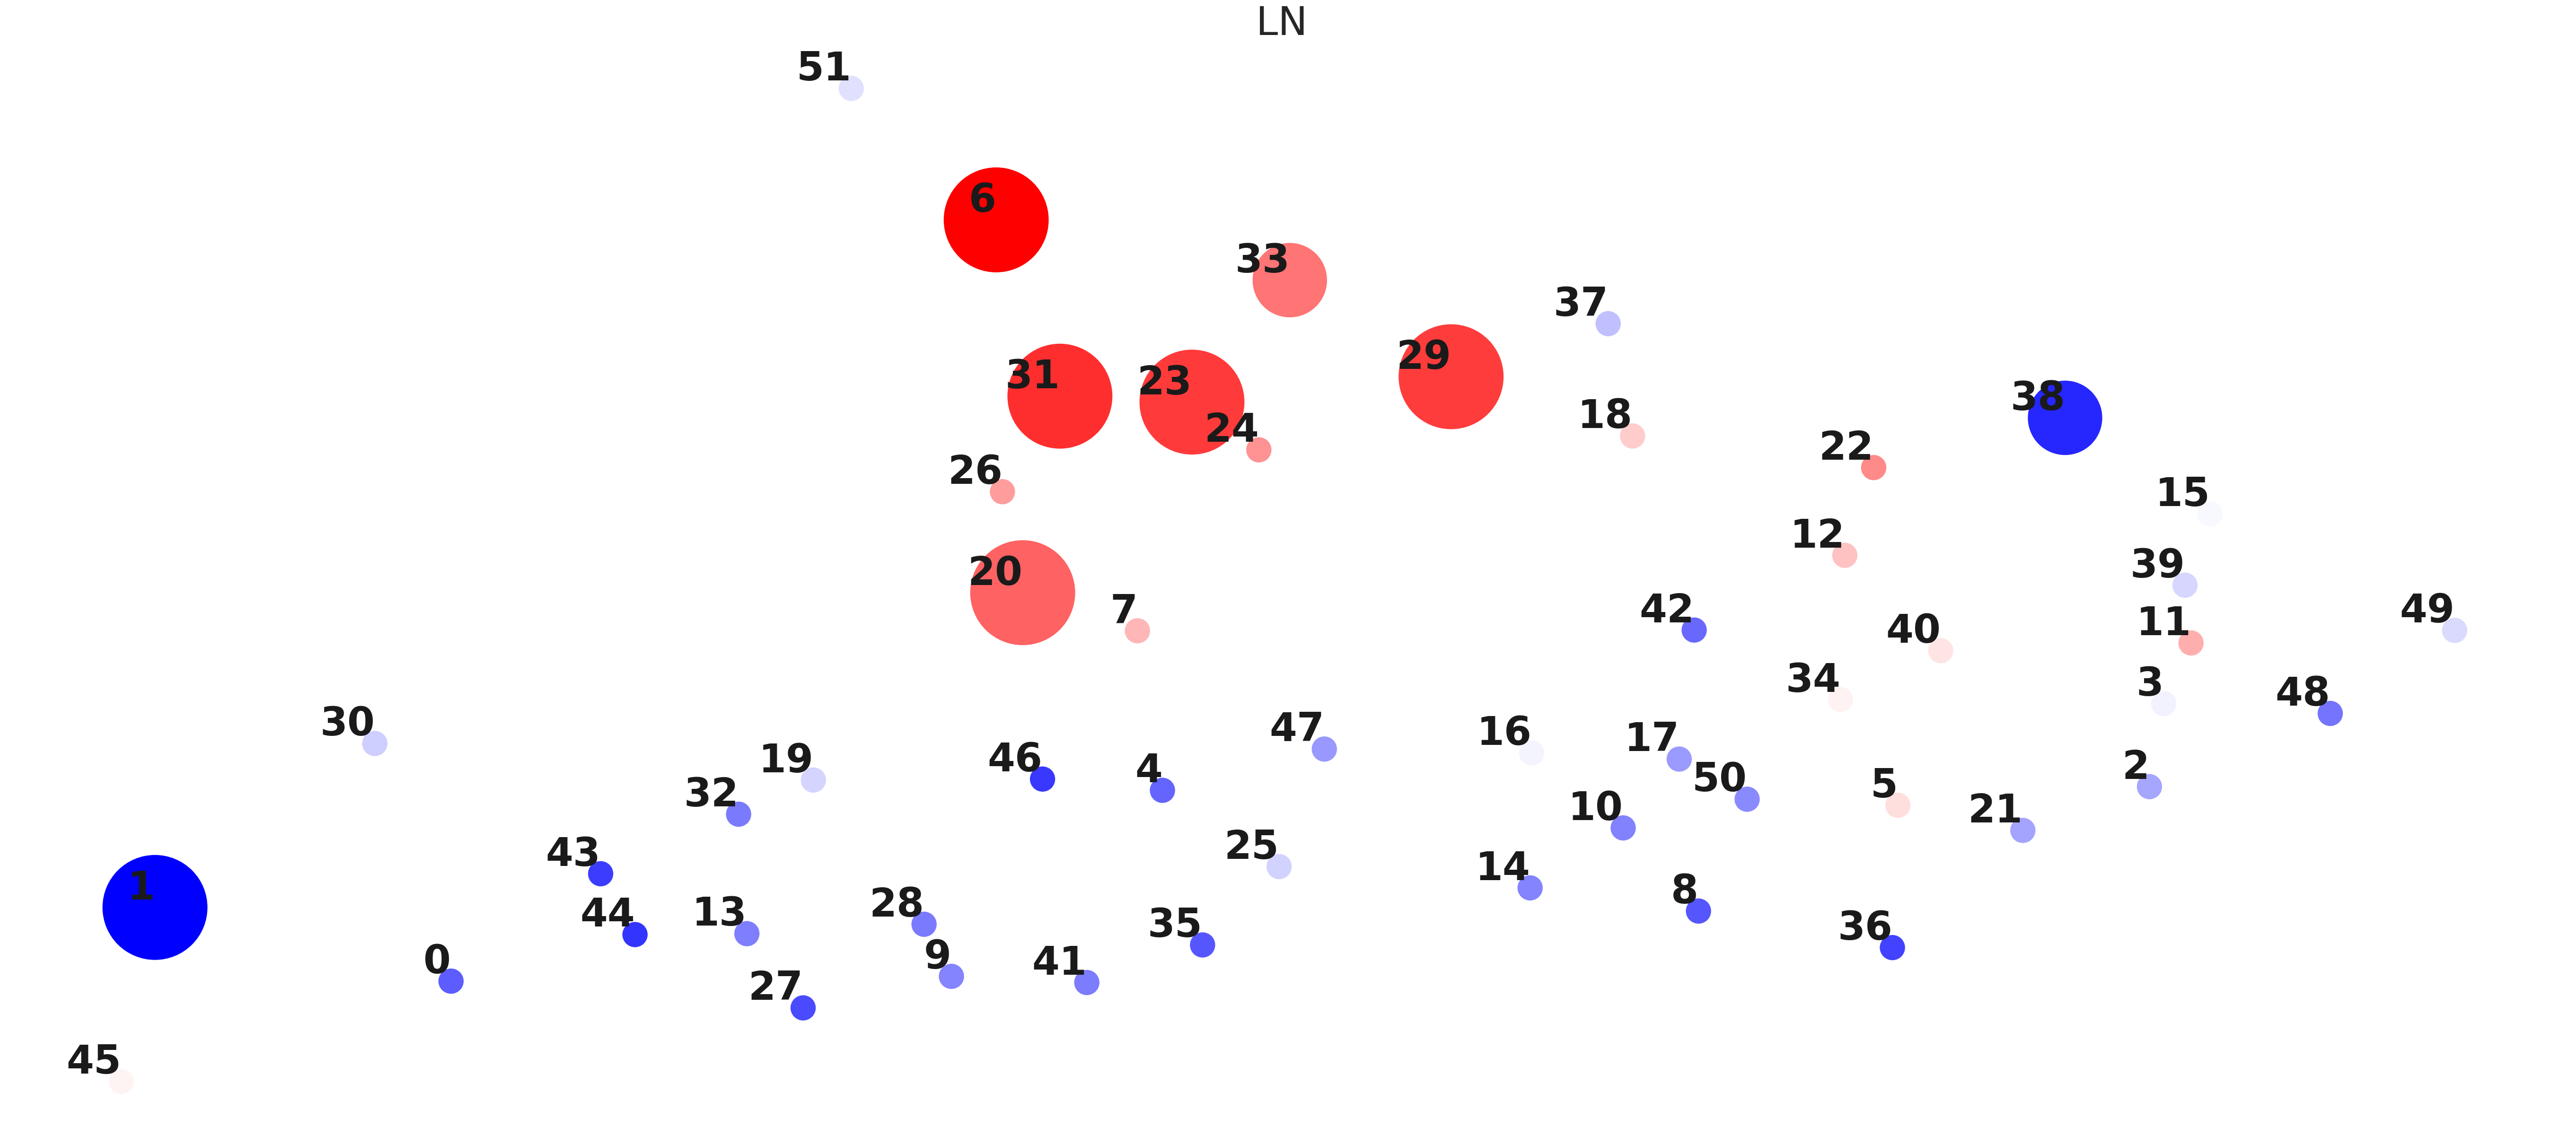

In [43]:
# Get p-values
pValues = p_values.copy()
pValues.index = pValues.index+'_p'
pValues = pValues.T
pValues[pValues<0.05] = 90
pValues[pValues<0.1] = 45
pValues[pValues<=1] = 5
pValues['leiden_2.0'] = pValues.index.astype(int)
#pValues

# Get c-index
Values = c_indexes_u.copy().T
Values['leiden_2.0'] = Values.index.astype(int)

# Combine p-values and c-index in 1 dataframe
Valuesf = Values.merge(pValues, on='leiden_2.0', how='left')

adata_trainPAGA = anndata.read_h5ad(h5ad_path.replace('.h5ad', '_paga.h5ad'))

cmpN = matplotlib.colors.LinearSegmentedColormap.from_list("", [(0, 'blue'), (0.5,'white'), (1,'red')])


for dset in p_values_vis.index:
    Ncolor = Valuesf[dset] #'BMSfaisal005']
    fig = plt.figure(figsize=(70,30))
    plt.scatter(adata_trainPAGA.uns['paga']['pos'][:,0],adata_trainPAGA.uns['paga']['pos'][:,1],s=Valuesf[dset+'_p']*280,c=Valuesf[dset],cmap=cmpN)
    for kk in range(len(Valuesf['leiden_2.0'].values)):
        plt.text(adata_trainPAGA.uns['paga']['pos'][kk,0],adata_trainPAGA.uns['paga']['pos'][kk,1],Valuesf['leiden_2.0'].values[kk], fontsize=60, horizontalalignment='right',verticalalignment='bottom',c='k',fontweight=1000)
    plt.title(dset+" ", fontsize=60)
    plt.axis('off')
    plt.show()
